# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [5]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 425


## Group Number : 1

## Student 1 
### Name : Marios Marinos
### ID : 5353106

## Student 2
### Name : Ynze ter Horst
### ID : 4701682

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [6]:
# Author : Marios Marinos 5353106
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from datetime import datetime
import random
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(precision=20)

df = pd.read_csv("data_for_student_case.csv", sep=',')

In [7]:
# drop all the rows that have refused as transaction since we don't know if it's fraud or not.
df = df[df['simple_journal'] != 'Refused']
# map non fraud transactions and fraud to 0 and 1 respectively.
categories = {'Settled': 0, 'Chargeback' : 1}
df['simple_journal'] = df['simple_journal'].map(categories)

# change the creation date to datetime to use later.
df['creationdate'] = pd.to_datetime(df['creationdate'])
df

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,482729,2015-11-03 18:57:01,SE,visadebit,453903.0,48100.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:21:58,SwedenAccount,email135821,ip125573,card83162
290378,482731,2015-11-03 08:12:14,SE,mcdebit,554501.0,195000.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:31:24,SwedenAccount,email259702,ip202029,card131519
290379,482732,2015-11-03 08:12:14,SE,visadebit,453903.0,52500.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:41:40,SwedenAccount,email32927,ip229869,card142173
290380,482733,2015-11-03 18:56:44,SE,mcdebit,554501.0,87700.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:50:07,SwedenAccount,email97400,ip200721,card141579


In [8]:
# use currency code + amount to convert all the amounts to the same currency code (EUR)
currencycode_to_eur = {'GBP' : 0.86863, 'AUD' : 1.5581, 'SEK' : 10.1640, 'MXN' : 24.2345, 'NZD' : 1.6738}
# row['amount'] / (currency_dict[row['currencycode']]*100)
# first map the currency code to the corresponding values e.g. GBP : 0.86 EUR and then multilpy it by amount
df['new_amount'] = df['amount'] / (df['currencycode'].map(lambda x : currencycode_to_eur[x]) *  100)
# drop the old amount + currency code.
df = df.drop(columns=['amount'])

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

Visualization of the amount of transactions through time for both 
fraud and non fraud cases to see if there was a pattern or a specific
day that they tend to steal. As it seems it's random 
when a transaction will be fraud, even in the peak of non fraud cases Black Friday
there are not many more fraud cases than the normal.

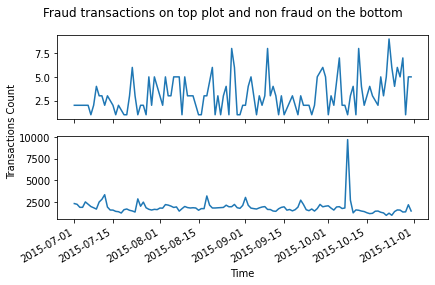

In [9]:
# rounding all creation dates to only day so for example 2015-11-03 08:12:14 ----> 2015-11-03 
df['day'] = df['creationdate'].dt.floor('d')

# group by day first and then which class it is to seperate the fraud and non fraud for each day.
new_df = df.groupby(["day",'simple_journal']).size().reset_index()
# drop the "temp" variable day.
df = df.drop(columns=['day'])
new_df = new_df.rename(columns= {0 : 'count'})

df_fraud = new_df[new_df['simple_journal'] == 1].reset_index()
df_not_fraud = new_df[new_df['simple_journal'] == 0]


fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Fraud transactions on top plot and non fraud on the bottom')
ax1.plot(df_fraud['day'], df_fraud['count'])
ax2.plot(df_not_fraud['day'], df_not_fraud['count'])
ax2.set_xlabel("Time")
fig.text(0.001, 0.55, 'Transactions Count', va='center', rotation='vertical')
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

fig.tight_layout()



Initial thought was to see where the criminals are targeting and whether
there is a pattern in the amount of transactions. As it seems, they focus 
more on "normal amount transactions" and not focusing on high amount transactions.

Text(0.5, 1.0, 'Box plot for non Fraud cases')

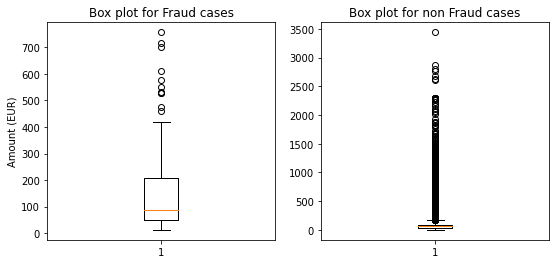

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

df_fraud = df[df['simple_journal'] == 1]
df_non_fraud = df[df['simple_journal'] == 0]
ax1.boxplot(df_fraud['new_amount'])
ax2.boxplot(df_non_fraud['new_amount'])
ax1.set_ylabel("Amount (EUR)")
ax1.set_title("Box plot for Fraud cases")
ax2.set_title("Box plot for non Fraud cases")

Bar chart for each different country containing information of
the average count of transactions before encountering a fraudulent transaction
(log-scaled). It mainly answers the question which country is more
likely to have fraudalent cases.

Text(0.5, 1.0, 'Average count of transactions before encountering a fraudulent transaction')

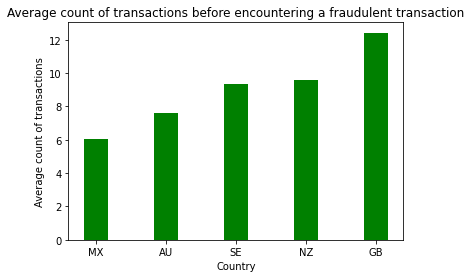

In [11]:
shoppercountrycode = df_fraud.groupby(by=["shoppercountrycode"]).sum()

country_fraud = pd.concat([df['shoppercountrycode'].value_counts(),shoppercountrycode], axis=1).dropna() 

country_fraud = country_fraud[country_fraud['simple_journal'] > 2]

country_fraud['ratio'] = np.log2(country_fraud['shoppercountrycode'] / country_fraud['simple_journal'])

country_fraud = country_fraud.sort_values(by=['ratio'], ascending=True)

plt.bar(country_fraud.index, country_fraud['ratio'], color = 'g', width=0.35)
plt.xlabel('Country')
plt.ylabel('Average count of transactions')
plt.title('Average count of transactions before encountering a fraudulent transaction')


### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

In [12]:
# see where the NaN values are.
df.isna().sum()
# drop all the nan values for now, later try to predict them? Sample somehow.
df = df.dropna()
# reset indeces after dropping the nan values.
df = df.reset_index(drop=True)
# seperate the category (fraud or not) from the features.
is_fraud = df['simple_journal']
is_fraud = is_fraud.reset_index(drop=True)
df = df.drop(columns=['txid', 'simple_journal', 'bookingdate', 'creationdate', 'bin'])

In [13]:
# import category_encoders as ce
# # create the encoder using class simple journal.
# encoder=ce.TargetEncoder() 
# # fit the encoder with the data : transform the categorical variables w.r.t label (fraud or not)
# enc_data = encoder.fit_transform(df['shoppercountrycode'], is_fraud)
# enc_data

In [14]:
# # Convert all the rest columns which are of type 'object'
# char_cols = X_train.dtypes.pipe(lambda x: x[x == 'object']).index
# for c in char_cols:
#     # label encoding with pd.factorize
#     X_train[c], x = pd.get_dummies(X_train[c])

In [15]:
# split the data of the data frame
copy_df = df.copy()
copy_df = copy_df.drop(columns=['mail_id','card_id', 'ip_id' ])
# scale the non categorical variables before encoding.
num_cols = copy_df.columns[copy_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(copy_df[num_cols]),columns = num_cols)
# replace all the scaled values to the new data frame
copy_df[num_cols] = df_scaled[num_cols]

copy_df = pd.get_dummies(copy_df)

# transform the dataframe to a numpy array.
copy_df = copy_df.to_numpy()

In [16]:
# Classification group part 
# apply smote 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek 
from collections import Counter

In [17]:
from scipy.stats import zscore
def removeOutliers(X, y, threshold):
    z_scores = zscore(X)

    abs_z_scores = np.abs(z_scores)
    print(abs_z_scores)

    filtered_entries = (abs_z_scores < threshold).all(axis=1) 
    # print(abs_z_scores < threshold)           
    # print(filtered_entries)
    # filter out the outliers from the fraud cases
    new_df = X[(filtered_entries) & (y == 1)]
    new_y = y[(filtered_entries) & (y == 1)]

    return new_df, new_y


In [19]:
# X,y = removeOutliers(copy_df, is_fraud, 100000)

In [20]:
# set up 10-fold validation
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 
np.seterr(divide='ignore', invalid='ignore')
splits = 10

kf = KFold(n_splits=splits, shuffle=True)
# split the data set BEFORE smoting.
kf.get_n_splits(copy_df)

# initialize an empty array to keep track of tn, fp, fn, tp
arr = np.zeros((splits, 4))

for which_split, (train_index, test_index) in enumerate(kf.split(copy_df)):
    # print("TRAIN : {} , TEST : {}".format(train_index, test_index))
    X_train, X_test = copy_df[train_index], copy_df[test_index]
    y_train, y_test = is_fraud[train_index], is_fraud[test_index]
    sm = SMOTE(random_state=42)
    X_smote, y_smote = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_smote))
    print(X_smote.shape, y_smote.shape)
    # random undersample the data so as not to overfit.
    # X_smote, y_smote = removeOutliers(X_smote, y_smote, 100000)
    # print('Resampled dataset shape %s' % Counter(y_smote))
    # clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
    clf.fit(X_smote, y_smote)
    # tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    arr[which_split] = confusion_matrix(y_test, clf.predict(X_test)).ravel()



Resampled dataset shape Counter({1: 200844, 0: 200844})
(401688, 286) (401688,)


KeyboardInterrupt: 

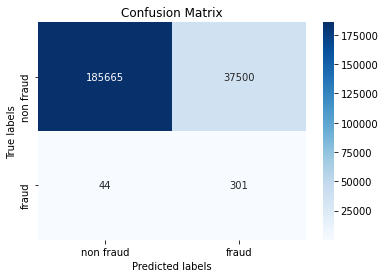

In [34]:
# reshape the array to a confusion matrix.
cm = sum(arr).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['non fraud', 'fraud']); ax.yaxis.set_ticklabels(['non fraud', 'fraud']);

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below